# Loading and working with processed fetal Visium data - post cell2location deconvolution

In [2]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import scipy.stats
from numpy import asarray as ar
from collections import Counter
import anndata as ad
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())
sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.9.1, on 2023-08-16 17:50.


In [3]:
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [5]:
# output folder 
import os
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure6/')
adata_cite_full = sc.read_h5ad('adata_cite_full_v11.h5ad')

In [ ]:
v

In [7]:
# filter spots by coverage
sc.pp.filter_genes(adata_cite_full,min_counts=2) # retain at least 3 levels of expression 0,1,2
adata_cite_filt = adata_cite_full[adata_cite_full.obs['tot_cell_abundance']>30,:].copy()
adata_cite_filt = adata_cite_filt[adata_cite_filt.obs['n_genes_by_counts']>1000,:]
adata_cite_filt = adata_cite_filt[adata_cite_filt.obs['annotations_level_0']!='Artifacts']
adata_cite_filt = adata_cite_filt[adata_cite_filt.obs['annotations_level_0']!='Background']
adata_cite_filt = adata_cite_filt[adata_cite_filt.obs['annotations_level_0']!='Unassigned']
adata_cite_filt = adata_cite_filt[~adata_cite_filt.obs['annotations_level_0'].isna()]

del adata_cite_full
adata_cite_filt

View of AnnData object with n_obs × n_vars = 25505 × 28164
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding',

In [8]:
# remove artifacts structures 
import warnings
warnings.filterwarnings('ignore')

adata_cite_cma = adata_cite_filt[adata_cite_filt.obs['annotations_level_1']!="Fat"].copy()

## remove meduala less lobules 
adata_cite_cma.obs['full_lobule'] = 0
for s in adata_cite_cma.obs['SampleID'].cat.categories.tolist():
    sample = adata_cite_cma[adata_cite_cma.obs['SampleID'].isin([s])]
    for l in sample.obs['annotations_lobules_0'].cat.categories:
        lobule = sample.obs['annotations_lobules_0'] == l
        med = np.where(sample.obs['annotations_level_0'][lobule] == 'Medulla')[0]
        cortex = np.where(sample.obs['annotations_level_0'][lobule] == 'Cortex')[0]
        if (cortex.size>=5) & (med.size>=5):
            adata_cite_cma.obs['full_lobule'][lobule.iloc[np.where(lobule)].index] = 1
adata_cite_cma.obs['full_lobule'] = adata_cite_cma.obs['full_lobule'].astype('category')
adata_cite_cma.obs['full_lobule'].value_counts()
adata_cite_cma = adata_cite_cma[adata_cite_cma.obs['full_lobule']==1] # remove spots that don't have either medullar or cortical data

sc.set_figure_params(figsize=[7,7],fontsize=20,dpi=100)
# sc.pl.umap(adata_cite_cma, color ='annotation_figure_1', frameon = False,s=5)

1    22616
0     2889
Name: full_lobule, dtype: int64

# Explore gene expression and cytokine profiles  

# correlations with axis 

In [11]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/ImageSpot/')
import imagespot as ims
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level I','Cortical level II','Cortical level III','Cortical CMJ','Medullar CMJ','Medullar level I','Medullar level II','Medullar level III']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_cite_cma.obs = ims.bin_axis(ct_order ,ct2_values,adata_cite_cma.obs,'cma_v2')   
adata_cite_cma.obs.loc[adata_cite_cma.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'

Cortical level II     4089
Cortical level I      3639
Cortical level III    2566
Capsular              2175
Medullar level III    2061
Cortical CMJ          1915
Medullar CMJ          1898
Medullar level I      1513
Sub-Capsular          1512
Medullar level II     1248
Name: manual_bin_cma_v2, dtype: int64

<AxesSubplot:>

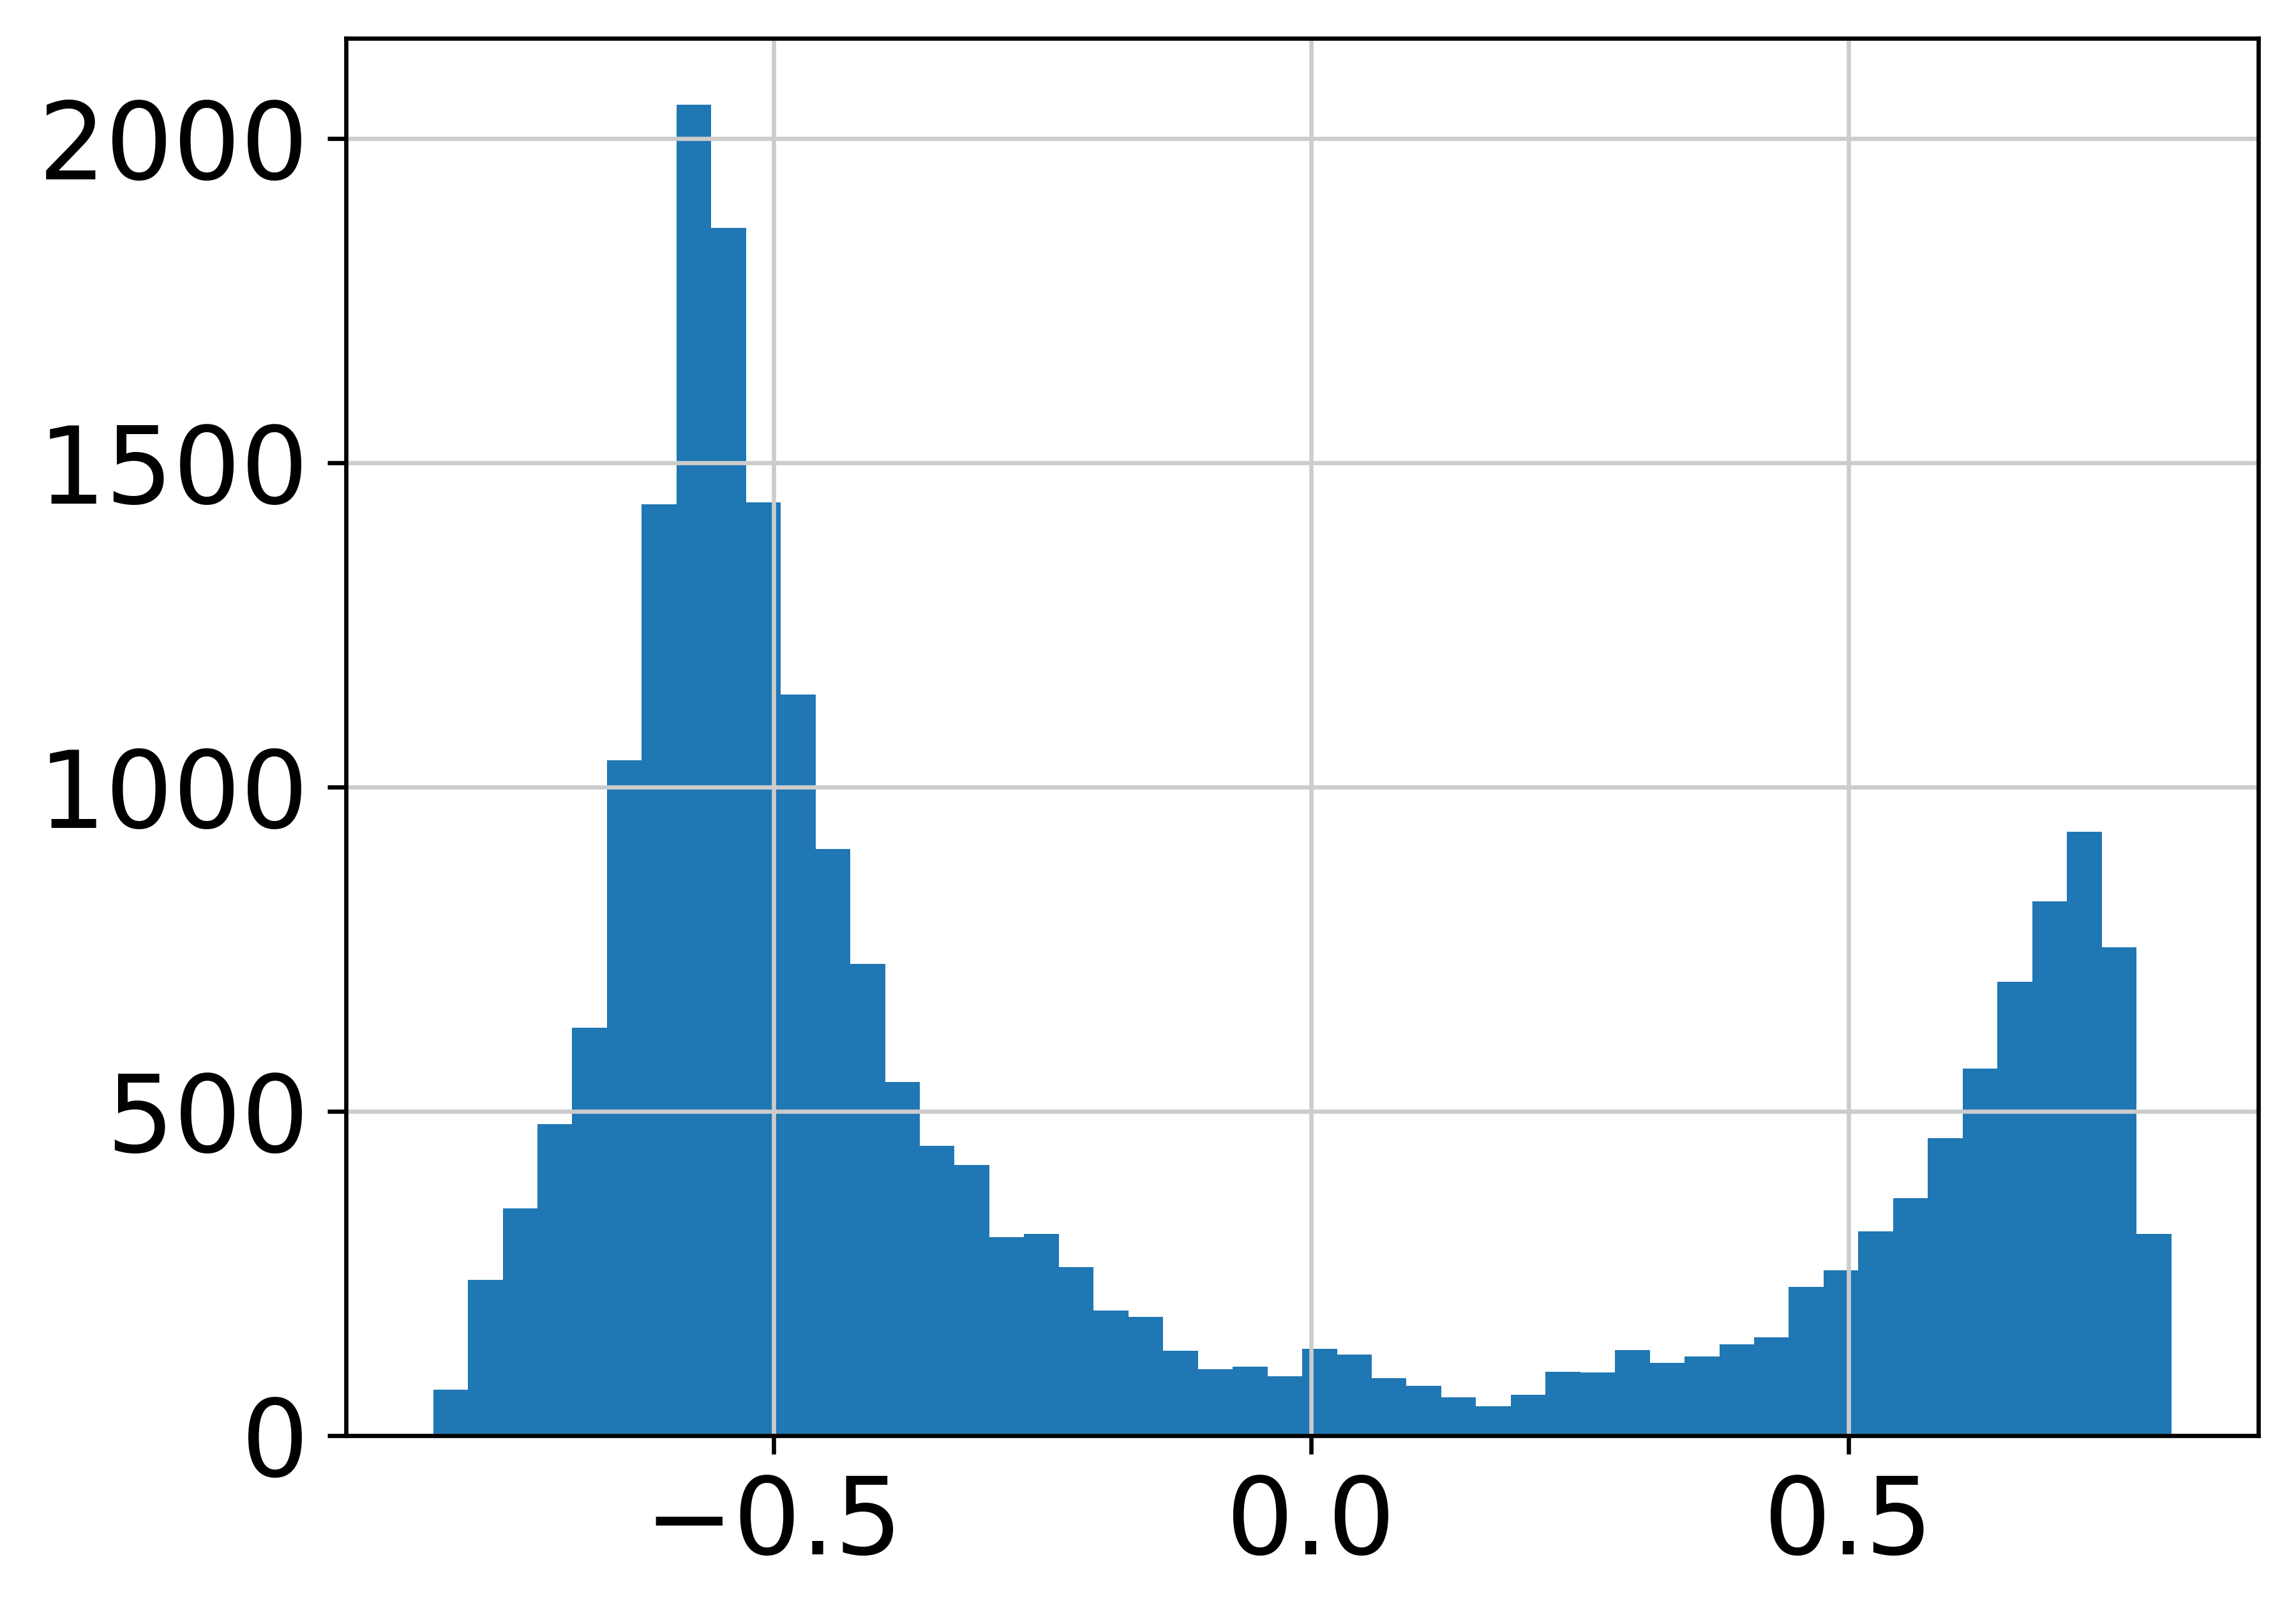

In [13]:
adata_cite_cma.obs['manual_bin_cma_v2'] = adata_cite_cma.obs['manual_bin_cma_v2'].astype('category')
adata_cite_cma.obs['manual_bin_cma_v2'] = adata_cite_cma.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_cite_cma.obs['manual_bin_cma_v2'].value_counts()
adata_cite_cma.obs['cma_v2'].hist(bins=50)
plt.show()

# Analyse cell level

In [71]:
celltypes = adata_cite_cma.uns['mod']['factor_names']
cellab_cite = sc.AnnData(adata_cite_cma.obs[celltypes], 
                         obs = adata_cite_cma.obs.drop(celltypes, axis = 1),obsm = adata_cite_cma.obsm)

cellab_cite.var_names
sc.pp.normalize_total(cellab_cite,target_sum=100)
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure6/')


Index(['B-memory', 'B-naive', 'B-plasma', 'CD8aaII_immature', 'CD8aaII_mature',
       'CD8aaI_immature', 'CD8aaI_mature', 'DC1', 'DC2', 'DP(P)_early',
       'DP(P)_late', 'DP(Q)_CD199', 'DP(Q)_CD99_CD31hi', 'DP(Q)_CD99_CD31lo',
       'DP(Q)_HSPH1', 'DP(Q)_Th2', 'DP(Q)_early', 'DP(Q)_rearr', 'DP_4hi8lo',
       'DP_early_CD31', 'DP_pos_sel', 'EC-Art', 'EC-Art-ELN', 'EC-Cap',
       'EC-Lymphatic', 'EC-Ven', 'InterloFb', 'Macrophage-APOC2',
       'Macrophage-SPIC1', 'Monocyte_IL1B', 'Myelocyte', 'NKT_dev',
       'NK_circ_56hi16lo', 'NK_tr_itg_hi', 'NK_tr_itg_lo', 'Neutrophil',
       'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'PeriloFb', 'SMC',
       'SP_CD4_immature', 'SP_CD4_mature', 'SP_CD4_semimature',
       'SP_CD8_immature', 'SP_CD8_mature', 'SP_CD8_memory',
       'SP_CD8_semimature', 'SP_Treg_CD8', 'SP_Treg_PD1', 'SP_Treg_immature',
       'SP_Treg_mature', 'SP_Treg_recirc', 'TEC-cilliated', 'TEC-myo',
       'TEC-neuro', 'aDC1', 'aDC2', 'aDC3', 'cTECI', 'cTECII', 'c

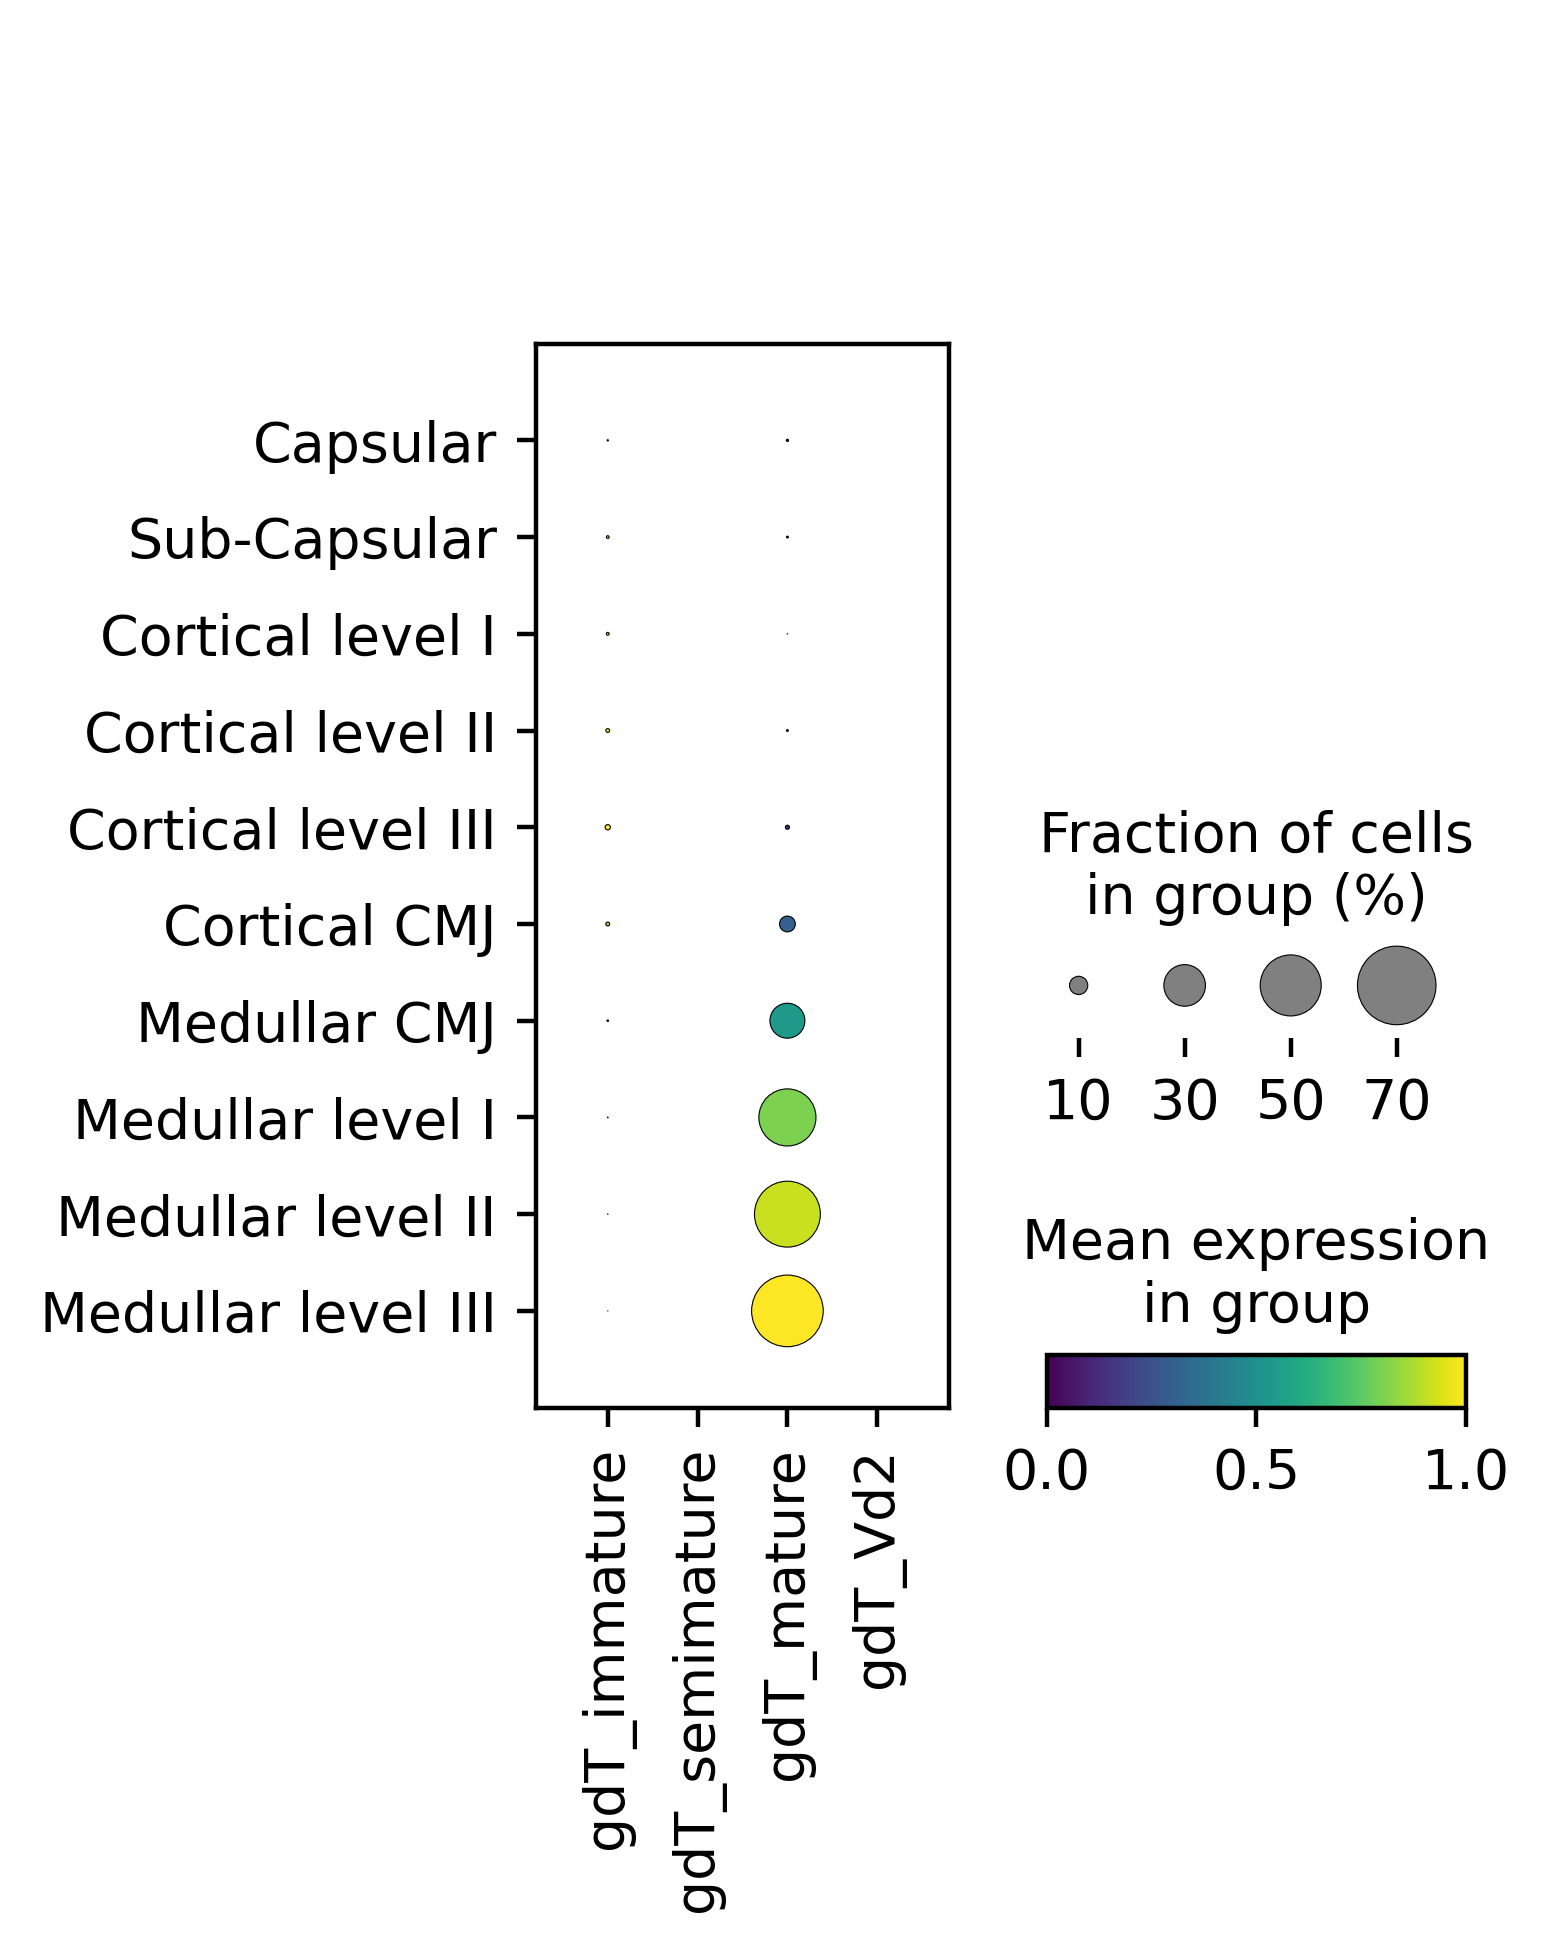

In [151]:

# cells = ['CD8aaI_immature', 'CD8aaI_mature','CD8aaII_immature', 'CD8aaII_mature',]
# cells = ['DP(P)_early','DP(P)_late', 'DP(Q)_early','DP(Q)_rearr']
# cells = ['DP(Q)_CD199','DP(Q)_CD99_CD31hi', 'DP(Q)_CD99_CD31lo', 'DP(Q)_Th2','DP(Q)_HSPH1']
# cells = ['NKT_dev','NK_circ_56hi16lo', 'NK_tr_itg_hi', 'NK_tr_itg_lo']
# cells = ['DP_pos_sel', 'DP_4hi8lo' ,'SP_CD4_immature', 'SP_CD4_semimature','SP_CD4_mature', 'SP_CD8_immature', 'SP_CD8_semimature','SP_CD8_mature', ]
# cells = ['SP_Treg_mature', 'SP_Treg_recirc',  'SP_Treg_CD8', 'SP_Treg_PD1', 'SP_Treg_immature']
# cells = [ 'committed_CD4neg(P)','committed_CD4neg','committed_CD4pos','committed_CD4pos(P)','DP_early_CD31',]
# cells = ['uncommitted']
# cells = [ 'gdT_immature', 'gdT_semimature','gdT_mature','gdT_Vd2',]

cutoff = 1
sc.set_figure_params(figsize=[7,7],fontsize=12,dpi=200)
sc.pl.dotplot(cellab_cite,var_names=cells,
               groupby='manual_bin_cma_v2',cmap='viridis',expression_cutoff=cutoff,standard_scale='var',save='paed_cite_gd_cutoff'+str(cutoff)+'.pdf')
              